In [1]:
import numpy as np
import pandas as pd
import tensorflow
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from tensorflow.keras.layers import BatchNormalization
from keras.utils import np_utils
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline

In [2]:
data = pd.read_csv("coffee_reviews.csv")
#data=data.loc[data['stars_x']>=3]

In [3]:
data['sentiment'] = 0* data['stars_x']
def sent(num):
    num=int(num)
    if num<=3:
        return 0
    if num>3:
        return 1
data['sentiment']=data.stars_x.apply(sent)
data.text = data.text.str.lower()

## remove unnecessary punctuation
data['clean_text']= data.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')

/tmp/ipykernel_254114/3415193883.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data['clean_text']= data.text.str.replace('\n',''). \


In [4]:
from sklearn.model_selection import train_test_split
X,X_test,y,y_test = train_test_split(data,data.sentiment,stratify=data.sentiment,test_size=0.2,random_state=11)
x_train,x_valid,y_train,y_valid = train_test_split(X,X.sentiment,stratify=X.sentiment,test_size=0.3,random_state=11)


In [5]:
#using glove embeddings
from tqdm import tqdm
embeddings_index = {}
f = open('glove.840B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except ValueError :
        continue
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

2196018it [01:24, 25849.49it/s]

Found 2195885 word vectors.


In [6]:
def sent2vec(s):
    words = str(s)
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [7]:
xtrain_glove = [sent2vec(x) for x in tqdm(x_train.clean_text)]
xvalid_glove = [sent2vec(x) for x in tqdm(x_valid.clean_text)]

100%|███████████████████████████████████| 29764/29764 [00:08<00:00, 3560.62it/s]


In [8]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)
xtrain_glove.shape

(69449, 300)

In [9]:
#scaling train and validation sets
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

We start with a simple Logistic regression model.

In [10]:
lreg=LogisticRegression(max_iter=1000,C=100)
lreg.fit(xtrain_glove_scl,y_train)
print("Train accuracy : ",lreg.score(xtrain_glove_scl,y_train))
print("Validation accuracy : ",lreg.score(xvalid_glove_scl,y_valid))

Train accuracy :  0.8710996558625754
Validation accuracy :  0.8689020292971374


In [11]:
print(classification_report(lreg.predict(xvalid_glove_scl),y_valid))

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      8132
           1       0.93      0.89      0.91     21632

    accuracy                           0.87     29764
   macro avg       0.83      0.85      0.84     29764
weighted avg       0.87      0.87      0.87     29764



<AxesSubplot:>

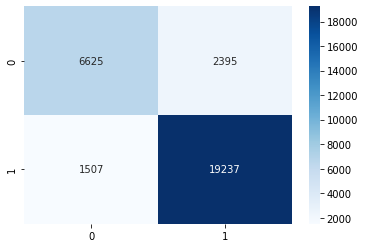

In [12]:
cm = confusion_matrix(y_valid , lreg.predict(xvalid_glove_scl))
sns.heatmap(cm, annot=True,fmt='', cmap='Blues')


In [13]:
ytrain_enc = np_utils.to_categorical(y_train)
yvalid_enc = np_utils.to_categorical(y_valid)

In [14]:
#initial sequential model
model = Sequential()

model.add(Dense(512, input_dim=300, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('sigmoid'))

# compile the model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(),metrics=['accuracy'],)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               154112    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

2022-01-10 06:48:18.548834: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 06:48:18.549168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 06:48:18.582821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 06:48:18.583152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-10 06:48:18.583410: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [15]:
history= model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=50, verbose=1,
          validation_data=(xvalid_glove_scl, yvalid_enc), callbacks=[earlystop])

Epoch 1/50
  34/1086 [..............................] - ETA: 5s - loss: 0.5948 - accuracy: 0.7169

2022-01-10 06:48:21.150337: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1086/1086 [==============================] - 7s 5ms/step - loss: 0.3662 - accuracy: 0.8454 - val_loss: 0.3309 - val_accuracy: 0.8573
Epoch 2/50
1086/1086 [==============================] - 6s 5ms/step - loss: 0.3298 - accuracy: 0.8625 - val_loss: 0.3056 - val_accuracy: 0.8712
Epoch 3/50
1086/1086 [==============================] - 6s 5ms/step - loss: 0.3201 - accuracy: 0.8659 - val_loss: 0.3039 - val_accuracy: 0.8712
Epoch 4/50
1086/1086 [==============================] - 6s 5ms/step - loss: 0.3135 - accuracy: 0.8693 - val_loss: 0.3094 - val_accuracy: 0.8697
Epoch 5/50
1086/1086 [==============================] - 6s 5ms/step - loss: 0.3122 - accuracy: 0.8703 - val_loss: 0.3012 - val_accuracy: 0.8753
Epoch 6/50
1086/1086 [==============================] - 6s 5ms/step - loss: 0.3076 - accuracy: 0.8731 - val_loss: 0.3008 - val_accuracy: 0.8737
Epoch 7/50
1086/1086 [==============================] - 6s 5ms/step - loss: 0.3029 - accuracy: 0.8749 - val_loss: 0.3010 - val_accuracy: 0.8741
Epo

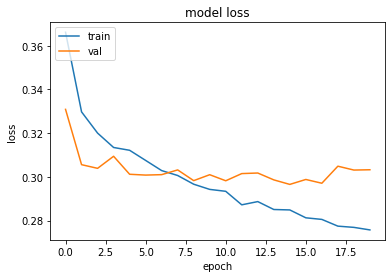

In [16]:
#loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

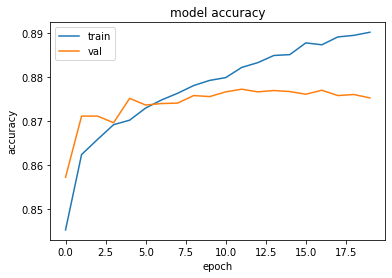

In [17]:
#accuracy plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
model.save('glove_seq.h5')

In [19]:
print(classification_report(np.argmax(model.predict(xvalid_glove_scl),axis=1),y_valid))

              precision    recall  f1-score   support

           0       0.71      0.86      0.77      7442
           1       0.95      0.88      0.91     22322

    accuracy                           0.88     29764
   macro avg       0.83      0.87      0.84     29764
weighted avg       0.89      0.88      0.88     29764



<AxesSubplot:>

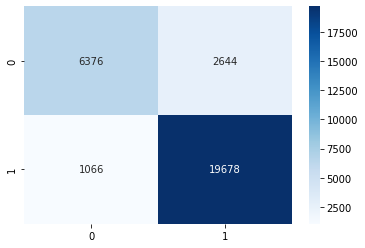

In [20]:
cm = confusion_matrix(y_valid , np.argmax(model.predict(xvalid_glove_scl),axis=1))
sns.heatmap(cm, annot=True,fmt='', cmap='Blues')

In [21]:
# using keras tokenizer here
token = text.Tokenizer(oov_token=True, num_words=None)
max_len = 100

token.fit_on_texts(list(x_train.clean_text))
xtrain_seq = token.texts_to_sequences(x_train.clean_text)
xvalid_seq = token.texts_to_sequences(x_valid.clean_text)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [22]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|███████████████████████████████| 103957/103957 [00:00<00:00, 721335.75it/s]


In [23]:
import keras
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
#model.add(LSTM(1028, dropout=0.2, recurrent_dropout=0.2))


model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))

model.add(Dense(2))
model.add(Activation('sigmoid'))
# compile the model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          31187400  
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 300)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 dense_5 (Dense)             (None, 1024)              132096    
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               131200    
                                                      

In [24]:
history_lstm = model.fit(xtrain_pad, y=ytrain_enc, batch_size=64, epochs=20, verbose=1, 
                         validation_data=(xvalid_pad, yvalid_enc),
                        callbacks=[earlystop])

Epoch 1/20
1086/1086 [==============================] - 300s 274ms/step - loss: 0.4047 - accuracy: 0.8230 - val_loss: 0.3020 - val_accuracy: 0.8695
Epoch 2/20
1086/1086 [==============================] - 298s 274ms/step - loss: 0.3123 - accuracy: 0.8694 - val_loss: 0.2978 - val_accuracy: 0.8773
Epoch 3/20
1086/1086 [==============================] - 298s 274ms/step - loss: 0.2934 - accuracy: 0.8785 - val_loss: 0.2765 - val_accuracy: 0.8872
Epoch 4/20
1086/1086 [==============================] - 298s 275ms/step - loss: 0.2794 - accuracy: 0.8857 - val_loss: 0.2856 - val_accuracy: 0.8829
Epoch 5/20
1086/1086 [==============================] - 298s 275ms/step - loss: 0.2690 - accuracy: 0.8904 - val_loss: 0.2846 - val_accuracy: 0.8933
Epoch 6/20
1086/1086 [==============================] - 298s 274ms/step - loss: 0.2619 - accuracy: 0.8938 - val_loss: 0.2657 - val_accuracy: 0.8962
Epoch 7/20
1086/1086 [==============================] - 299s 275ms/step - loss: 0.2532 - accuracy: 0.8982 - val_

In [25]:
model.save('glove_lstm.h5')

In [26]:
print(classification_report(np.argmax(model.predict(xvalid_pad),axis=1),y_valid))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      8039
           1       0.95      0.91      0.93     21725

    accuracy                           0.90     29764
   macro avg       0.86      0.89      0.88     29764
weighted avg       0.90      0.90      0.90     29764



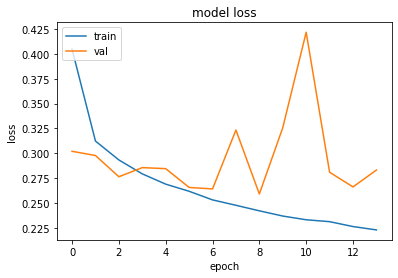

In [27]:
#loss plot
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

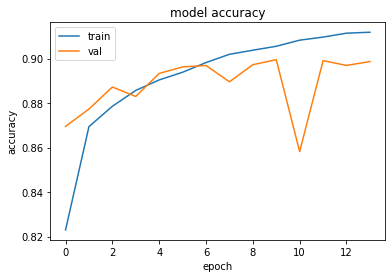

In [28]:
#accuracy plot
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<AxesSubplot:>

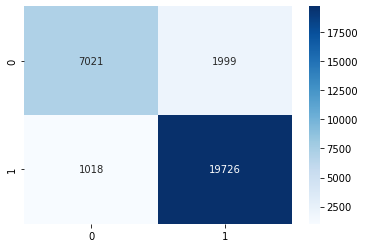

In [29]:
cm = confusion_matrix(y_valid , np.argmax(model.predict(xvalid_pad),axis=1))
sns.heatmap(cm, annot=True,fmt='', cmap='Blues')